# Word2Vec(skip gram)

In [0]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import os

In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
samples = ["창욱은 영화를 좋아한다",
          "창욱은 도서관을 좋아한다",
          "창욱은 공부를 좋아한다",
          "창욱은 축구를 좋아한다",
          "창욱은 수영을 좋아한다",
          "창욱은 야구를 좋아한다",
          "중현은 영화를 싫어한다", 
          "중현은 도서관을 싫어한다",
          "중현은 공부를 싫어한다", 
          "중현은 축구를 싫어한다", 
          "중현은 수영을 싫어한다", 
          "중현은 야구를 싫어한다",]

In [0]:
token_sentences = []

for sentence in samples:
  token_sentences.extend(sentence.split())

print("token_sentences : %s " %token_sentences)  
word_list = " ".join(samples).split()
word_list = list(set(word_list))

print("word_list : %s" %word_list)

token_sentences : ['창욱은', '영화를', '좋아한다', '창욱은', '도서관을', '좋아한다', '창욱은', '공부를', '좋아한다', '창욱은', '축구를', '좋아한다', '창욱은', '수영을', '좋아한다', '창욱은', '야구를', '좋아한다', '중현은', '영화를', '싫어한다', '중현은', '도서관을', '싫어한다', '중현은', '공부를', '싫어한다', '중현은', '축구를', '싫어한다', '중현은', '수영을', '싫어한다', '중현은', '야구를', '싫어한다'] 
word_list : ['중현은', '도서관을', '공부를', '좋아한다', '축구를', '싫어한다', '수영을', '야구를', '창욱은', '영화를']


In [0]:
char_to_int = dict((c, i) for i, c in enumerate(word_list))
print(char_to_int)

{'중현은': 0, '도서관을': 1, '공부를': 2, '좋아한다': 3, '축구를': 4, '싫어한다': 5, '수영을': 6, '야구를': 7, '창욱은': 8, '영화를': 9}


In [0]:
int_to_char = dict((i, c) for i, c in enumerate(word_list))
print(int_to_char)

{0: '중현은', 1: '도서관을', 2: '공부를', 3: '좋아한다', 4: '축구를', 5: '싫어한다', 6: '수영을', 7: '야구를', 8: '창욱은', 9: '영화를'}


In [0]:
skip_gram = []
print(word_list)
print(token_sentences)

for i in range(1, len(token_sentences) - 1):
    target = char_to_int[token_sentences[i]]
    contexts = [char_to_int[token_sentences[i - 1]], char_to_int[token_sentences[i + 1]]]
    
    for context in contexts:
        skip_gram.append([target, context])
        
print(skip_gram)

['중현은', '도서관을', '공부를', '좋아한다', '축구를', '싫어한다', '수영을', '야구를', '창욱은', '영화를']
['창욱은', '영화를', '좋아한다', '창욱은', '도서관을', '좋아한다', '창욱은', '공부를', '좋아한다', '창욱은', '축구를', '좋아한다', '창욱은', '수영을', '좋아한다', '창욱은', '야구를', '좋아한다', '중현은', '영화를', '싫어한다', '중현은', '도서관을', '싫어한다', '중현은', '공부를', '싫어한다', '중현은', '축구를', '싫어한다', '중현은', '수영을', '싫어한다', '중현은', '야구를', '싫어한다']
[[9, 8], [9, 3], [3, 9], [3, 8], [8, 3], [8, 1], [1, 8], [1, 3], [3, 1], [3, 8], [8, 3], [8, 2], [2, 8], [2, 3], [3, 2], [3, 8], [8, 3], [8, 4], [4, 8], [4, 3], [3, 4], [3, 8], [8, 3], [8, 6], [6, 8], [6, 3], [3, 6], [3, 8], [8, 3], [8, 7], [7, 8], [7, 3], [3, 7], [3, 0], [0, 3], [0, 9], [9, 0], [9, 5], [5, 9], [5, 0], [0, 5], [0, 1], [1, 0], [1, 5], [5, 1], [5, 0], [0, 5], [0, 2], [2, 0], [2, 5], [5, 2], [5, 0], [0, 5], [0, 4], [4, 0], [4, 5], [5, 4], [5, 0], [0, 5], [0, 6], [6, 0], [6, 5], [5, 6], [5, 0], [0, 5], [0, 7], [7, 0], [7, 5]]


In [0]:
context = []
target = []
for i in range(len(skip_gram)):
  context.append(skip_gram[i][0])  # context
  target.append(skip_gram[i][1])  # label

In [0]:
EPOCH_SIZE = 1500
BATCH_SIZE = 12

def train_input_fn():
  dataset = tf.data.Dataset.from_tensor_slices((context, target))
  dataset = dataset.repeat(EPOCH_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.shuffle(len(skip_gram))
  iterator = dataset.make_one_shot_iterator()
  
  return iterator.get_next()

In [0]:
VOCAB_SIZE = len(int_to_char) +1
EMB_SIZE = 2


def model_fn(features, labels, mode):
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    
#     w_1이라는 [VOCAB_SIZE, EMB_SIZE] 크기의 Variable을 만든다.
#     w_2라는 [VOCAB_SIZE, EMB_SIZE] 크기의 Variable을 만든다.
#     one hot encoding input을 만든다.
#     input과 w_1을 matmul을 통해서 hidden을 만든다.
#     hidden과 w_2를 matmul을 통해서 output을 가져온다.
    
    targets = tf.one_hot(indices=labels, depth=VOCAB_SIZE)

    loss = tf.losses.softmax_cross_entropy(targets, output)

    if TRAIN:
        global_step = tf.train.get_global_step()
        train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step)


    return tf.estimator.EstimatorSpec(
          mode=mode,
          train_op=train_op,
          loss=loss) 

In [0]:
# ANSWER
# VOCAB_SIZE = len(int_to_char) +1
# EMB_SIZE = 2


# def model_fn(features, labels, mode):
#     TRAIN = mode == tf.estimator.ModeKeys.TRAIN
#     EVAL = mode == tf.estimator.ModeKeys.EVAL
    
#     w_1 = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMB_SIZE], -1.0, 1.0))
#     w_2 = tf.Variable(tf.random_uniform([EMB_SIZE, VOCAB_SIZE], -1.0, 1.0))
    
#     input = tf.one_hot(indices=features, depth=VOCAB_SIZE)
    
#     hidden = tf.matmul(input, w_1)
    
#     output = tf.matmul(hidden, w_2)
    
#     targets = tf.one_hot(indices=labels, depth=VOCAB_SIZE)

#     loss = tf.losses.softmax_cross_entropy(targets, output)

#     if TRAIN:
#         global_step = tf.train.get_global_step()
#         train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step)


#     return tf.estimator.EstimatorSpec(
#           mode=mode,
#           train_op=train_op,
#           loss=loss) 

In [0]:
!rm -rf data_out;ls;

adc.json  gdrive  sample_data


In [0]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

estimator = tf.estimator.Estimator(model_fn = model_fn, model_dir = DATA_OUT_PATH + 'checkpoint/skip_gram')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './data_out/checkpoint/skip_gram', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f26c39ad080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
estimator.train(train_input_fn)

Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./data_out/checkpoint/skip_gram/model.ckpt.
INFO:tensorflow:loss = 2.741211, step = 1
INFO:tensorflow:global_step/sec: 964.139
INFO:tensorflow:loss = 2.4297783, step = 101 (0.106 sec)
INFO:tensorflow:global_step/sec: 1355.9
INFO:tensorflow:loss = 2.238477, step = 201 (0.075 sec)
INFO:tensorflow:global_step/sec: 1340.14
INFO:tensorflow:loss = 2.579564, step = 301 (0.077 sec)
INFO:tensorflow:global_step/sec: 1323.58
INFO:tensorflow:loss = 2.4680362, step = 401 (0.076 sec)
INFO:tensorflow:global_step/sec: 1255.1
INFO:tensorflow:loss = 2.5246036, step = 501 (0.075 sec)
INFO:tensorflow:global_st

In [0]:
variable_names = estimator.get_variable_names()

In [0]:
variable_names

['Variable',
 'Variable/Adam',
 'Variable/Adam_1',
 'Variable_1',
 'Variable_1/Adam',
 'Variable_1/Adam_1',
 'beta1_power',
 'beta2_power',
 'global_step']

In [0]:
emb = estimator.get_variable_value(variable_names[0])

In [0]:
emb

array([[-2.944615  ,  0.35831603],
       [ 0.4096597 , -2.317766  ],
       [ 0.41814312, -2.3762288 ],
       [ 0.8940689 ,  0.26823646],
       [ 0.40200162, -2.2760246 ],
       [ 2.5353928 ,  1.4902025 ],
       [ 0.3730933 , -2.1328816 ],
       [ 0.40665066, -2.3335698 ],
       [-1.5080035 , -0.01462691],
       [ 0.4159675 , -2.346128  ],
       [ 0.6557038 ,  0.8068681 ]], dtype=float32)

### 한글 폰드 설정

In [0]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name() 
print(font_name)
plt.rc('font', family=font_name)

NanumGothic Eco


In [0]:
fm._rebuild()

In [0]:
matplotlib.rcParams['axes.unicode_minus'] = False 

### 임베딩 그림 그리기

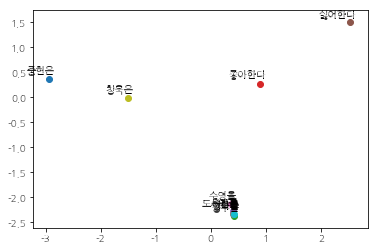

In [0]:

for i, label in enumerate(word_list):
    x, y = emb[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()